In [63]:
# codigo de la url: https://colab.research.google.com/drive/1wWvtA5RC6-is6J8W86wzK52Knr3N1Xbm#scrollTo=VBXq-Wb_K1XR

In [64]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [65]:
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
df.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,1577836800000,7195.24,7245.00,7175.46,7224.21,3646.232354,1577858399999,2.631450e+07,44901,1987.278850,1.434351e+07,0
1,1577858400000,7224.24,7237.73,7180.00,7197.20,4415.466238,1577879999999,3.182890e+07,51073,2173.642319,1.566963e+07,0
2,1577880000000,7197.20,7255.00,7196.15,7236.83,5443.680806,1577901599999,3.934948e+07,55857,3229.260535,2.334553e+07,0
3,1577901600000,7237.02,7246.72,7175.15,7200.85,3287.008767,1577923199999,2.372158e+07,42179,1556.773831,1.123912e+07,0
4,1577923200000,7200.77,7212.50,7116.70,7138.93,5561.311699,1577944799999,3.980317e+07,60466,2579.989270,1.846858e+07,0


In [66]:
# Change the time unit of the "open_time" and "close_time" columns
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

In [67]:
df.shape

(4984, 11)

Text(0, 0.5, 'Close Price (USD)')

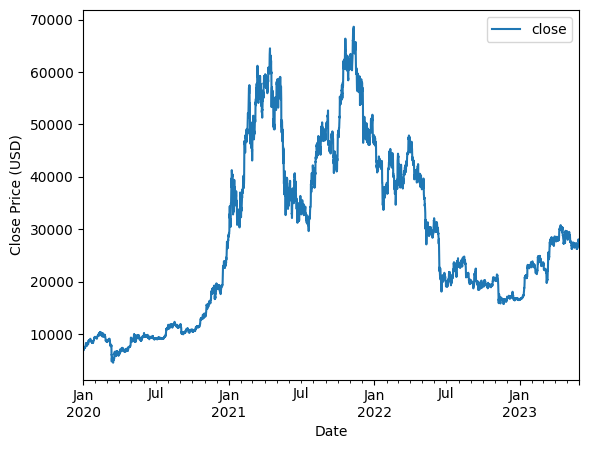

In [68]:
ax = df.plot(x='open_time', y='close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [69]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [70]:
scaled_close.shape

(4984, 1)

In [71]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [72]:


class Preprocessor:
    def __init__(self, SEQ_LEN=150):
        self.SEQ_LEN=SEQ_LEN
        pass
    def to_sequences(self, data, seq_len):
        d = []

        for index in range(len(data) - seq_len):
            d.append(data[index: index + seq_len])

        return np.array(d)

    def preprocess(self, data_raw, train_split):

        data = self.to_sequences(data_raw, self.SEQ_LEN)

        self.num_train = int(train_split * data.shape[0])

        X_train = data[:self.num_train, :-1, :]
        y_train = data[:self.num_train, -1, :]

        X_test = data[self.num_train:, :-1, :]
        y_test = data[self.num_train:, -1, :]

        return X_train, y_train, X_test, y_test

preprocessor=Preprocessor()
X_train, y_train, X_test, y_test = preprocessor.preprocess(scaled_close, train_split = 0.80)

In [73]:
df.shape[0]-preprocessor.num_train

1117

In [74]:
X_train.shape

(3867, 149, 1)

In [75]:
X_test.shape

(967, 149, 1)

# Model

In [76]:
from tensorflow.keras.layers import LSTM

DROPOUT = 0.2
WINDOW_SIZE = preprocessor.SEQ_LEN - 1

model = keras.Sequential()

model.add(LSTM(WINDOW_SIZE, return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[-1])),
                        )
model.add(Dropout(rate=DROPOUT))

model.add(LSTM(WINDOW_SIZE * 2, return_sequences=True))
model.add(Dropout(rate=DROPOUT))

model.add(LSTM(WINDOW_SIZE, return_sequences=False))

model.add(Dense(units=1,activation='relu'))

model.add(Activation('linear'))


# Training

In [77]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss",
                       patience=9,
                       mode="min",
                       restore_best_weights=True)

model.compile(
    loss='mean_squared_error',
    metrics=["mae"] ,
    optimizer='adam'
)

In [78]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,
    callbacks=[es]
)

Epoch 1/15
55/55 [==============================] - 126s 2s/step - loss: 0.0067 - mae: 0.0641 - val_loss: 3.4484e-04 - val_mae: 0.0158
Epoch 2/15
55/55 [==============================] - 99s 2s/step - loss: 0.0160 - mae: 0.1025 - val_loss: 0.0195 - val_mae: 0.1380
Epoch 3/15
55/55 [==============================] - 102s 2s/step - loss: 0.0451 - mae: 0.1628 - val_loss: 0.0105 - val_mae: 0.1004
Epoch 4/15
55/55 [==============================] - 102s 2s/step - loss: 0.0460 - mae: 0.1596 - val_loss: 0.0029 - val_mae: 0.0517
Epoch 5/15
55/55 [==============================] - 100s 2s/step - loss: 0.0247 - mae: 0.1210 - val_loss: 0.0087 - val_mae: 0.0926
Epoch 6/15
55/55 [==============================] - 101s 2s/step - loss: 0.0177 - mae: 0.1108 - val_loss: 0.0058 - val_mae: 0.0752
Epoch 7/15
55/55 [==============================] - 100s 2s/step - loss: 0.0130 - mae: 0.0882 - val_loss: 0.0056 - val_mae: 0.0739
Epoch 8/15
55/55 [==============================] - 100s 2s/step - loss: 0.0104 

In [86]:
MAE=scaler.inverse_transform([[model.evaluate(X_test, y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

31/31 [==============================] - 15s 493ms/step - loss: 0.0021 - mae: 0.0388
MAE for the test set: 7053.307840028555


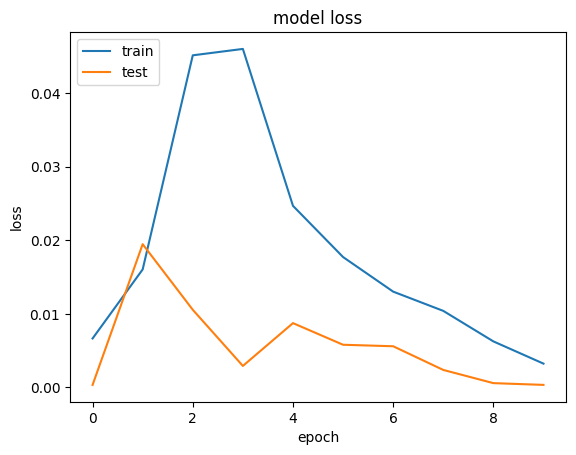

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [88]:
y_test.shape

(967, 1)

In [89]:
date_time_test=df.iloc[preprocessor.num_train+preprocessor.SEQ_LEN:,0].to_numpy()
date_time_test.shape

(967,)

31/31 [==============================] - 16s 511ms/step


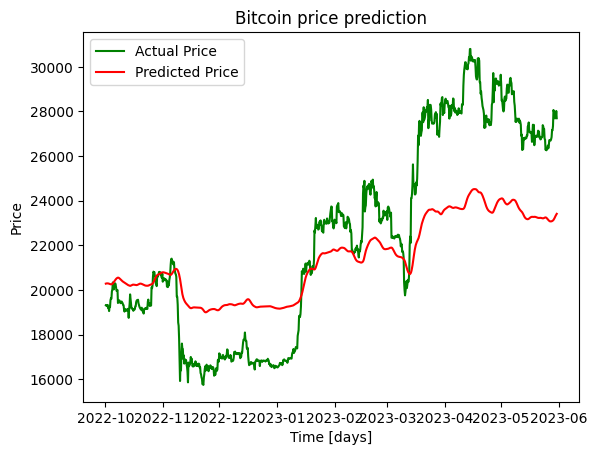

In [90]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

date_time_test=df.iloc[preprocessor.num_train+preprocessor.SEQ_LEN:,0].to_numpy()
 
plt.plot(date_time_test,y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test,y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

31/31 [==============================] - 16s 501ms/step


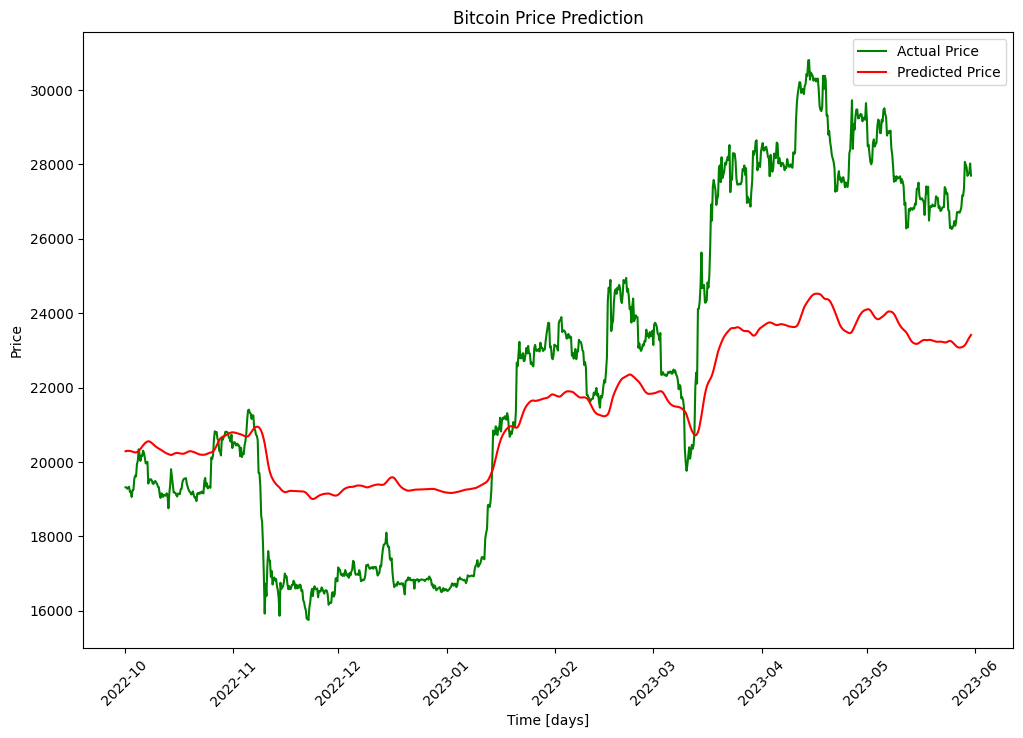

In [91]:
# Prediction
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

date_time_test = df.iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.legend(loc='best')

plt.show()


In [85]:
y_hat.shape

(967, 1)